In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

## DATA

In [2]:
raw_data = pd.read_csv('onlinefraud.csv')
data = raw_data.copy()

In [3]:
data = data.drop(['isFlaggedFraud'], axis=1)
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [5]:
data.duplicated().sum()

0

In [6]:
data.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
dtype: bool

In [7]:
data['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [8]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [9]:
fraud = data[data['isFraud'] == 1]
valid = data[data['isFraud'] == 0]
outliersFraction = len(fraud) / len(valid)
print('Outliers:', outliersFraction)
print('Cantidad de fraudes:', len(fraud))
print('Cantidad de validos:', len(valid))

Outliers: 0.0012924888191769902
Cantidad de fraudes: 8213
Cantidad de validos: 6354407


In [10]:
fraud['amount'].describe().round(2)

count        8213.00
mean      1467967.30
std       2404252.95
min             0.00
25%        127091.33
50%        441423.44
75%       1517771.48
max      10000000.00
Name: amount, dtype: float64

In [11]:
valid['amount'].describe().round(2)

count     6354407.00
mean       178197.04
std        596236.98
min             0.01
25%         13368.40
50%         74684.72
75%        208364.76
max      92445516.64
Name: amount, dtype: float64

In [12]:
## como podemos ver, la media de los fraudes es muchisimo mas alta que la media de las transacciones validas.

<Axes: >

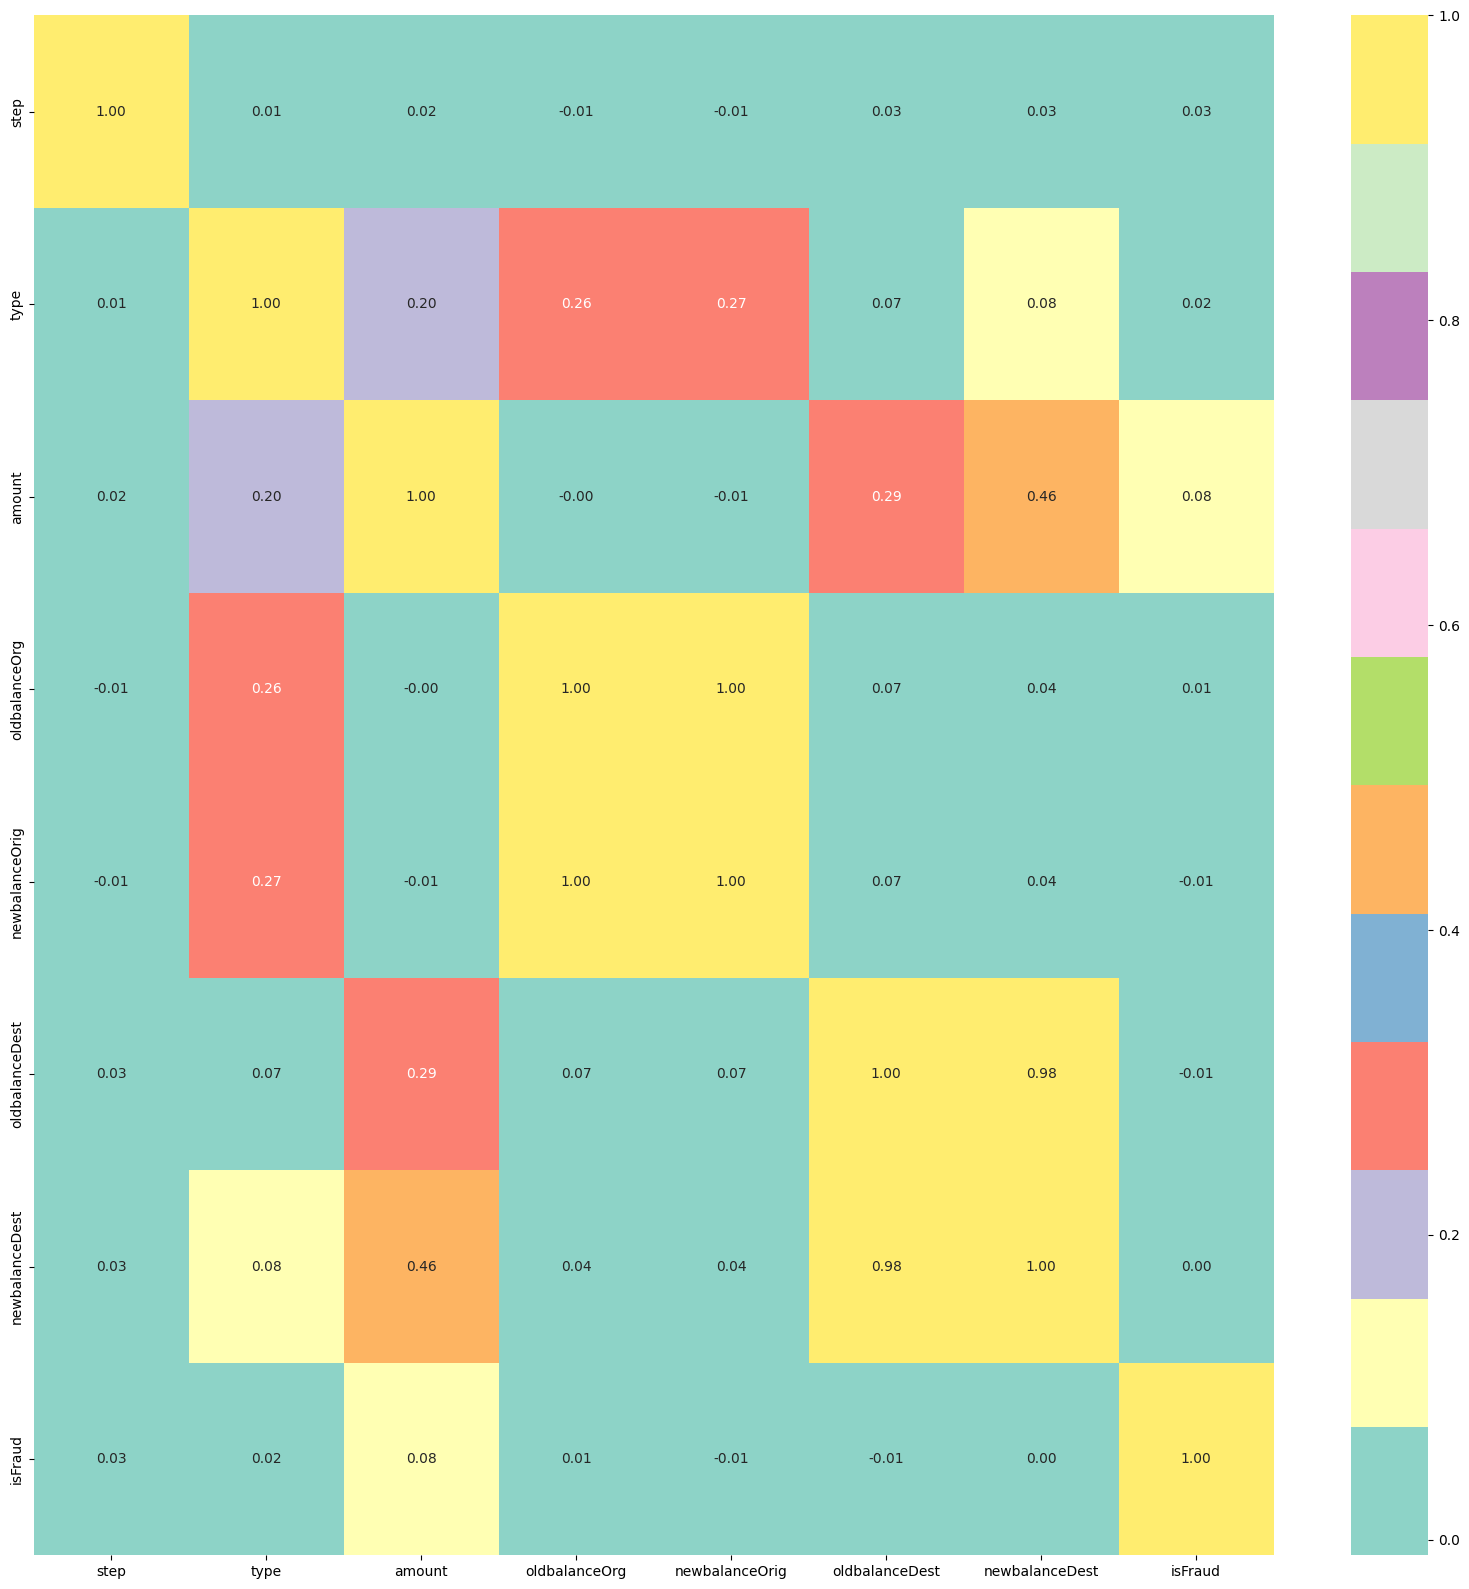

In [13]:
data_eda = data.copy()
data_eda['type'] = data_eda['type'].map({'CASH_OUT':1,'PAYMENT':2,'CASH_IN':3,'TRANSFER':4,'DEBIT':5})
data_eda['type'] = pd.to_numeric(data_eda['type'])
data_eda = data_eda.drop(['nameOrig','nameDest'], axis=1)

plt.figure(figsize=(20,20))
sns.heatmap(data_eda.corr(), fmt='.2f', annot=True, cmap='Set3')

Como podemos ver la mayoria de variables no tiene correlación, pero podemos detectar la alta correlación de oldbalance con newbalance, lo cual es obvio, y otras como Amount/newBalanceDest.

Pero en pocas palabras las categorias Amount y Type para ser las que tienen más correlaciones.

## MODELO

In [14]:
X = data_eda.drop(['isFraud'], axis=1)
Y = data_eda['isFraud']

print(X.shape)
print(Y.shape)

xData = X.values
yData = Y.values

(6362620, 7)
(6362620,)


In [15]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(xData, yData, train_size=0.8, test_size=0.2, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestClassifier

model_RFC = RandomForestClassifier()
model_RFC.fit(xTrain, yTrain)
yPred = model_RFC.predict(xTest)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix

acc = accuracy_score(yTest, yPred)
print('Accuracy:', acc)

pre = precision_score(yTest, yPred)
print('Precision:', pre)

rec = recall_score(yTest, yPred)
print('Recall:', rec)

f1 = f1_score(yTest, yPred)
print('F1 Score:', f1)

Accuracy: 0.9997351719888976
Precision: 0.9841509433962264
Recall: 0.8049382716049382
F1 Score: 0.8855687606112055


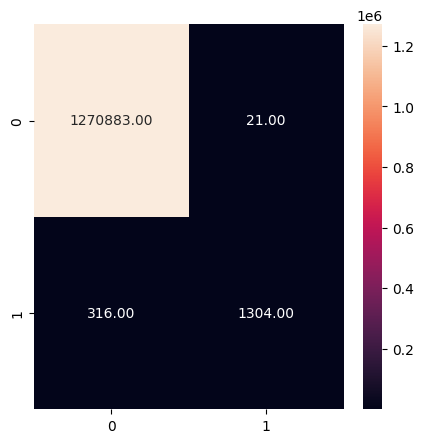

In [18]:
matrix = confusion_matrix(yTest, yPred)
plt.figure(figsize=(5,5))
sns.heatmap(matrix,fmt='.2f',annot=True)
plt.show()